In this guide, we will show how to generate novel images based on a text prompt using the KerasCV implementation of stability.ai's text-to-image model, Stable Diffusion.

Stable Diffusion is a powerful, open-source text-to-image generation model. While there exist multiple open-source implementations that allow you to easily create images from textual prompts, KerasCV's offers a few distinct advantages. These include XLA compilation and mixed precision support, which together achieve state-of-the-art generation speed.

In this guide, we will explore KerasCV's Stable Diffusion implementation, show how to use these powerful performance boosts, and explore the performance benefits that they offer.

To get started, let's install a few dependencies and sort out some imports:

pip3 install tensorflow keras_cv --upgrade --quiet
apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [13]:
import time
import tensorflow as tf
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt

In [14]:
devices = tf.config.list_physical_devices()
print(devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [6]:
model = keras_cv.models.StableDiffusion(img_width=512, img_height=512)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


198180272/198180272 [==============================] - 3s 0us/step


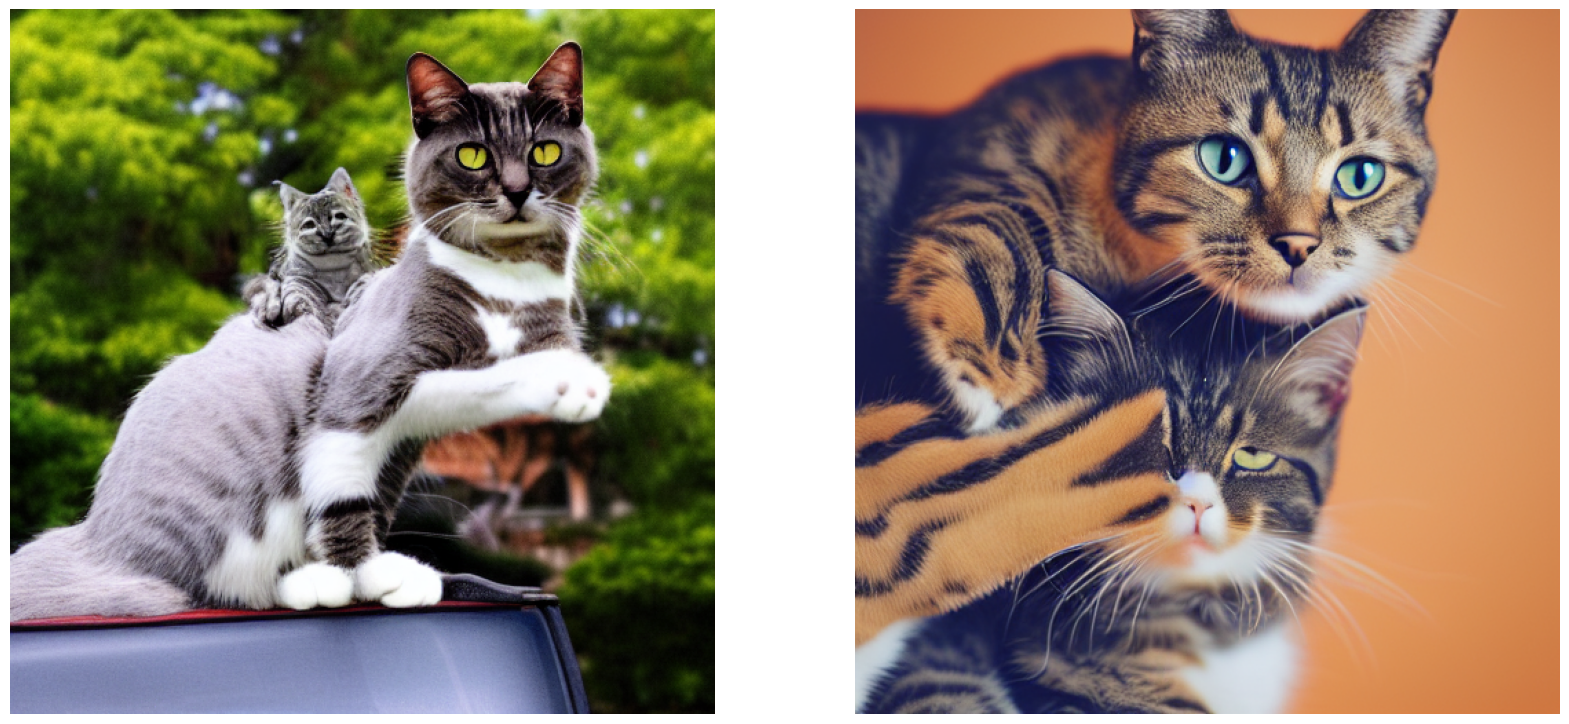

In [8]:
images = model.text_to_image("photograph of an cat riding a cat", batch_size=2)

def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

plot_images(images)

In [11]:
print(type(images))
keras.mixed_precision.set_global_policy("mixed_float16")

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


50/50 [==============================] - 493s 10s/step


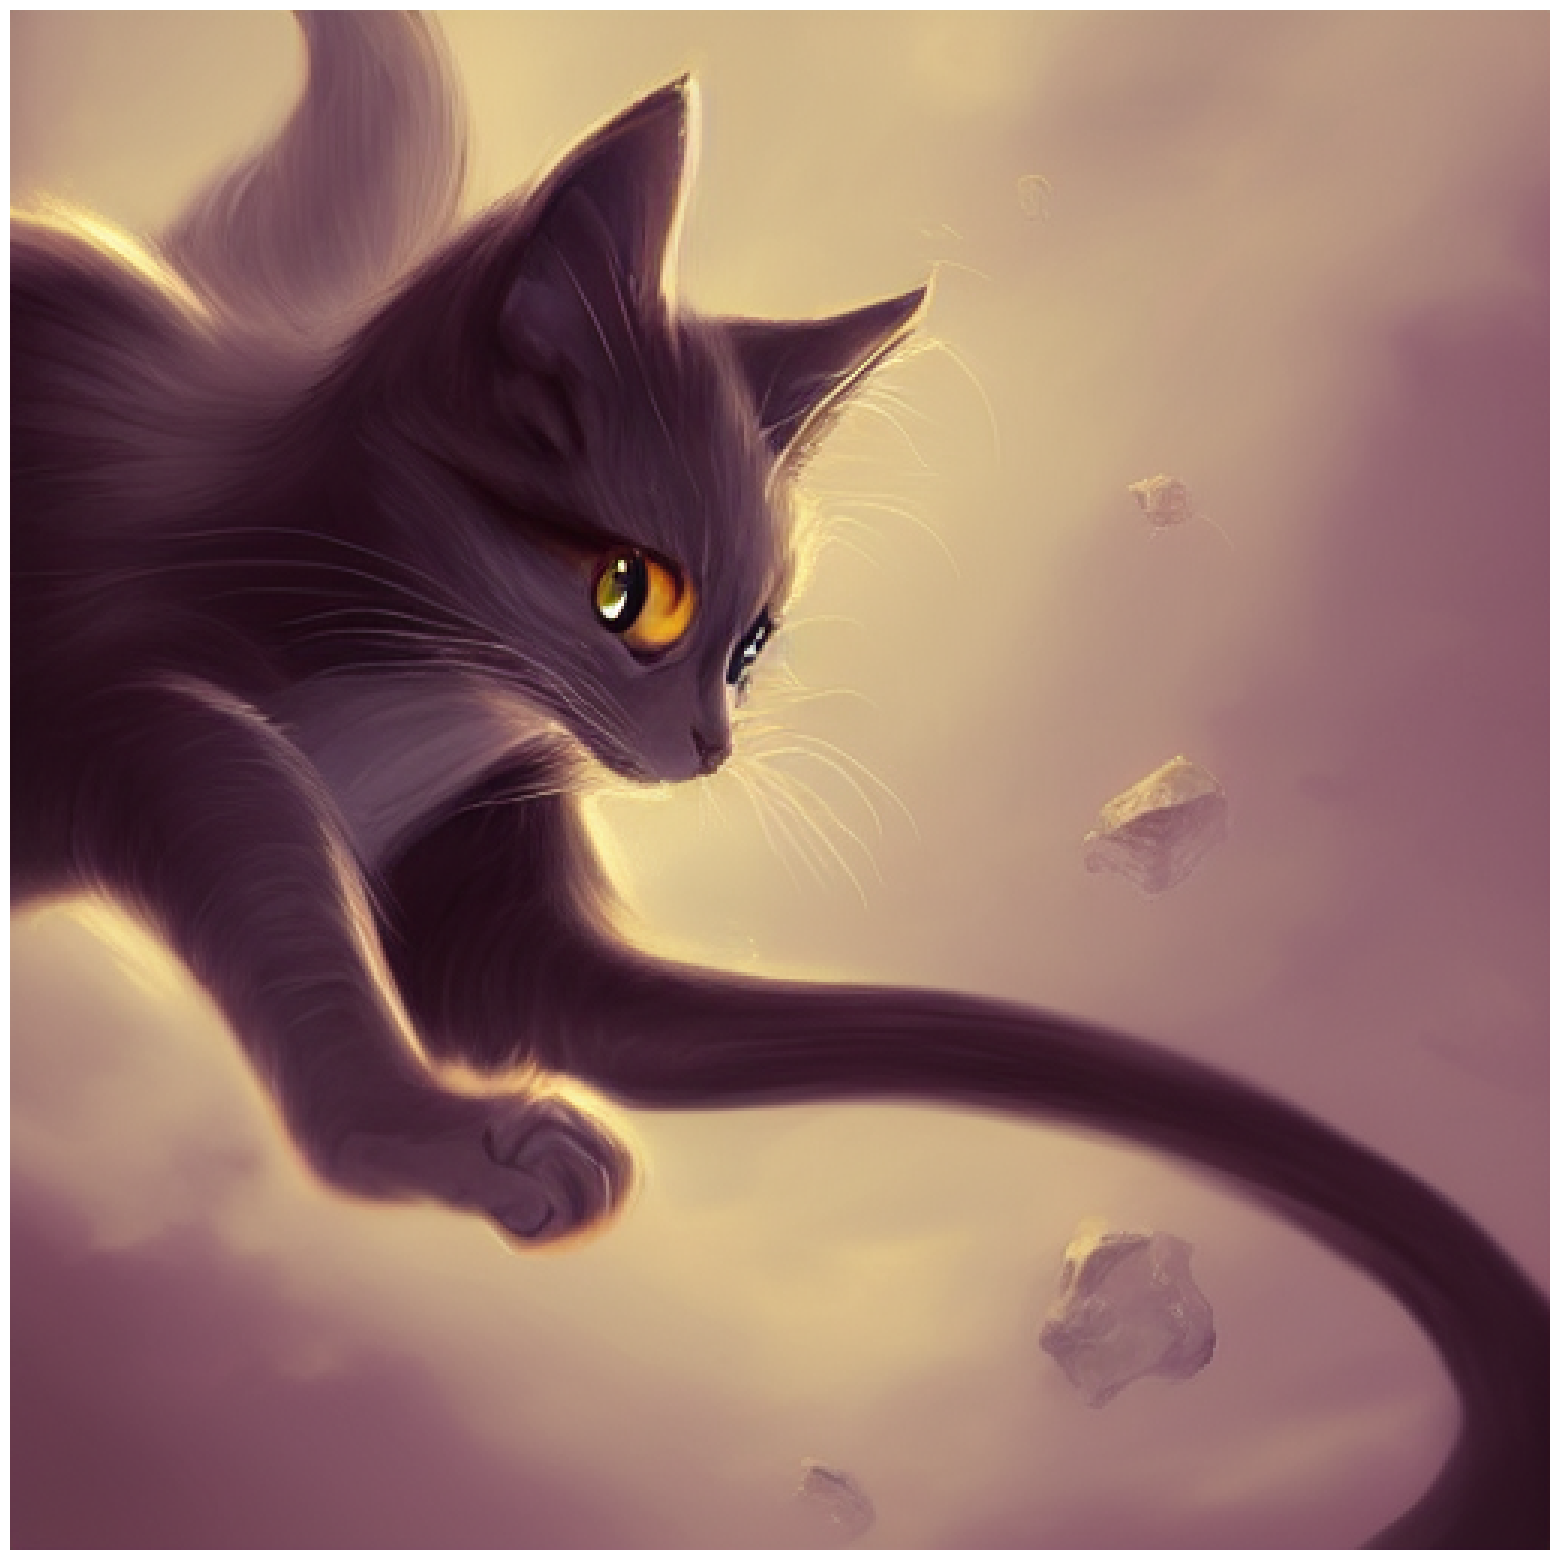

In [15]:
images = model.text_to_image(
    "cute magical flying cat, fantasy art, "
    "black color, high quality, highly detailed, elegant, sharp focus, "
    "concept art, character concepts, digital painting, mystery, adventure",
    batch_size=1,
)
plot_images(images)

In [17]:
tf.keras.utils.save_img("stable_diffusion/cute_flying_magical_cat.png", images)

TypeError: save_img() missing 1 required positional argument: 'x'

50/50 [==============================] - 1165s 23s/step


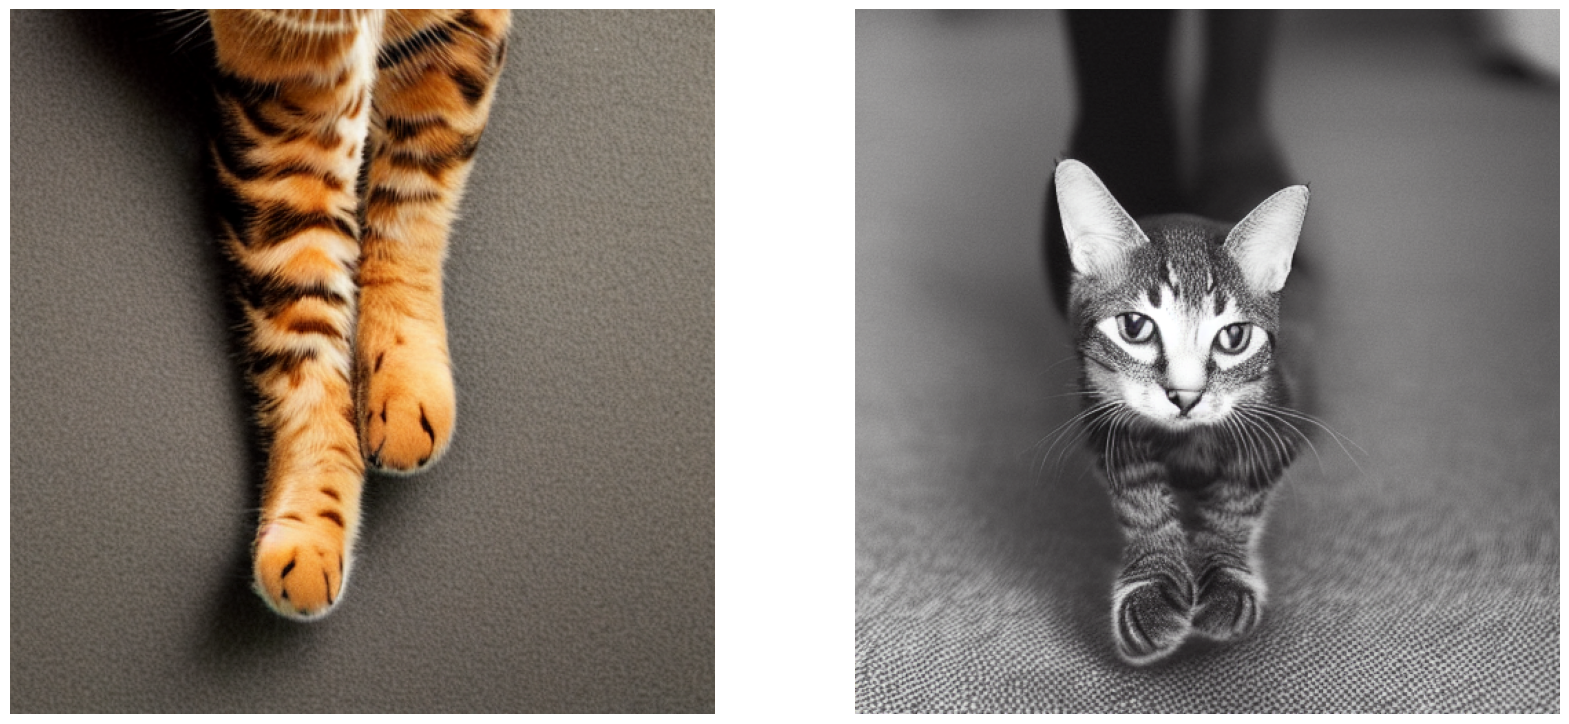

In [16]:
images = model.text_to_image("photograph of an cat with human legs and feet", batch_size=2)

def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

plot_images(images)

Wait, how does this even work?
Unlike what you might expect at this point, StableDiffusion doesn't actually run on magic. It's a kind of "latent diffusion model". Let's dig into what that means.

You may be familiar with the idea of super-resolution: it's possible to train a deep learning model to denoise an input image -- and thereby turn it into a higher-resolution version. The deep learning model doesn't do this by magically recovering the information that's missing from the noisy, low-resolution input -- rather, the model uses its training data distribution to hallucinate the visual details that would be most likely given the input. To learn more about super-resolution, you can check out the following Keras.io tutorials:

Image Super-Resolution using an Efficient Sub-Pixel CNN
Enhanced Deep Residual Networks for single-image super-resolution
Super-resolution

When you push this idea to the limit, you may start asking -- what if we just run such a model on pure noise? The model would then "denoise the noise" and start hallucinating a brand new image. By repeating the process multiple times, you can get turn a small patch of noise into an increasingly clear and high-resolution artificial picture.

This is the key idea of latent diffusion, proposed in High-Resolution Image Synthesis with Latent Diffusion Models in 2020. To understand diffusion in depth, you can check the Keras.io tutorial Denoising Diffusion Implicit Models.

Denoising diffusion

Now, to go from latent diffusion to a text-to-image system, you still need to add one key feature: the ability to control the generated visual contents via prompt keywords. This is done via "conditioning", a classic deep learning technique which consists of concatenating to the noise patch a vector that represents a bit of text, then training the model on a dataset of {image: caption} pairs.

This gives rise to the Stable Diffusion architecture. Stable Diffusion consists of three parts:

A text encoder, which turns your prompt into a latent vector.
A diffusion model, which repeatedly "denoises" a 64x64 latent image patch.
A decoder, which turns the final 64x64 latent patch into a higher-resolution 512x512 image.
First, your text prompt gets projected into a latent vector space by the text encoder, which is simply a pretrained, frozen language model. Then that prompt vector is concatenate to a randomly generated noise patch, which is repeatedly "denoised" by the decoder over a series of "steps" (the more steps you run the clearer and nicer your image will be -- the default value is 50 steps).

Finally, the 64x64 latent image is sent through the decoder to properly render it in high resolution.

The Stable Diffusion architecture

All-in-all, it's a pretty simple system -- the Keras implementation fits in four files that represent less than 500 lines of code in total:

text_encoder.py: 87 LOC
diffusion_model.py: 181 LOC
decoder.py: 86 LOC
stable_diffusion.py: 106 LOC
But this relatively simple system starts looking like magic once you train on billions of pictures and their captions. As Feynman said about the universe: "It's not complicated, it's just a lot of it!"

Perks of KerasCV
With several implementations of Stable Diffusion publicly available why shoud you use keras_cv.models.StableDiffusion?

Aside from the easy-to-use API, KerasCV's Stable Diffusion model comes with some powerful advantages, including:

Graph mode execution
XLA compilation through jit_compile=True
Support for mixed precision computation
When these are combined, the KerasCV Stable Diffusion model runs orders of magnitude faster than naive implementations. This section shows how to enable all of these features, and the resulting performance gain yielded from using them.

For the purposes of comparison, we ran benchmarks comparing the runtime of the HuggingFace diffusers implementation of Stable Diffusion against the KerasCV implementation. Both implementations were tasked to generate 3 images with a step count of 50 for each image. In this benchmark, we used a Tesla T4 GPU.

All of our benchmarks are open source on GitHub, and may be re-run on Colab to reproduce the results. The results from the benchmark are displayed in the table below:

GPU	Model	Runtime
Tesla T4	KerasCV (Warm Start)	28.97s
Tesla T4	diffusers (Warm Start)	41.33s
Tesla V100	KerasCV (Warm Start)	12.45
Tesla V100	diffusers (Warm Start)	12.72
30% improvement in execution time on the Tesla T4!. While the improvement is much lower on the V100, we generally expect the results of the benchmark to consistently favor the KerasCV across all NVIDIA GPUs.

For the sake of completeness, both cold-start and warm-start generation times are reported. Cold-start execution time includes the one-time cost of model creation and compilation, and is therefore neglible in a production environment (where you would reuse the same model instance many times). Regardless, here are the cold-start numbers:

GPU	Model	Runtime
Tesla T4	KerasCV (Cold Start)	83.47s
Tesla T4	diffusers (Cold Start)	46.27s
Tesla V100	KerasCV (Cold Start)	76.43
Tesla V100	diffusers (Cold Start)	13.90
While the runtime results from running this guide may vary, in our testing the KerasCV implementation of Stable Diffusion is significantly faster than its PyTorch counterpart. This may be largely attributed to XLA compilation.

In [ ]:
# To get started, let's first benchmark our unoptimized model:
benchmark_result = []
start = time.time()
images = model.text_to_image(
    "A cute black cat in a rainbow whirlpool fighting a white wizard, watercolor",
    batch_size=2,
)
end = time.time()
benchmark_result.append(["Standard", end - start])
plot_images(images)

print(f"Standard model: {(end - start):.2f} seconds")
keras.backend.clear_session()  # Clear session to preserve memory.

16/50 [========>.....................] - ETA: 11:47